In [17]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Desenvolvimento de um classificador que identifica se a parte recorrente é empresa ou empregado

## Carregamento dos datasets

In [18]:
import pandas as pd

df_tudo = pd.read_csv( "..//..//3_Preparacao_dos_dados//3_2_Anotacao_manual//Datasets_anotados_manual_final//Recorrente_anotado_manual.csv" )
df_tudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RECORRENTE  538 non-null    object
 1   TRIBUNAL    538 non-null    object
 2   ROTULO      538 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.7+ KB


## Ajustes e limpeza

In [19]:
#limpeza de caracteres em branco
df_tudo["RECORRENTE"] = df_tudo["RECORRENTE"].astype(str).map(str.strip)
#shuffle your dataframe in-place and reset the index
df_tudo = df_tudo.sample(frac=1).reset_index(drop=True)
df_tudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RECORRENTE  538 non-null    object
 1   TRIBUNAL    538 non-null    object
 2   ROTULO      538 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.7+ KB


In [20]:
df_tudo["ROTULO"].unique()

array([1, 0])

## Visualização da distribuição da classes

In [21]:
EMPRESA = 0
EMPREGADO = 1

<AxesSubplot:>

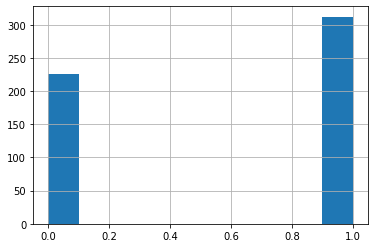

In [22]:
df_tudo["ROTULO"].hist()

In [23]:
df_tudo["ROTULO"].value_counts()

1    312
0    226
Name: ROTULO, dtype: int64

## Separação da base para testes finais

30% para testes finais. 70% para treinamento por meio de Cross Validation em 7 camadas.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_tudo["RECORRENTE"], df_tudo["ROTULO"], test_size=0.3, random_state=0)

In [25]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Importação de bibliotecas e definição de variáveis

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.offline import iplot

#https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
#https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [27]:
medias_cv = pd.DataFrame( )

def treinar_cv(model, nome_classificador):
    conf_matrix_list_of_arrays = []
    metricas_modelo = []
    cv = 7
    kf = KFold(n_splits=cv, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X_train):

        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_predicted = model.predict(X_test_cv)

        #METRICAS
        accuracy = accuracy_score(y_test_cv, y_predicted)
        f1 = f1_score(y_test_cv, y_predicted)
        precision = precision_score(y_test_cv, y_predicted)
        recall = recall_score(y_test_cv, y_predicted)

        metricas_cv = [accuracy, f1, precision, recall]
        metricas_modelo.append( metricas_cv ) 

        #confusion matrix
        conf_matrix = confusion_matrix(y_test_cv, y_predicted, labels=[EMPRESA, EMPREGADO])
        conf_matrix_list_of_arrays.append(conf_matrix)

    #calcula media da Confusion matrix
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
    c = mean_of_conf_matrix_arrays
    #normaliza a matriz = transforma a contagem de instancias em porcentagem
    #https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
    normed_c = (c.T / c.astype(np.float).sum(axis=1)).T

    
    #Grafico da Confusion matrix
    x = ["EMPRESA", "EMPREGADO"]
    y = ["EMPRESA", "EMPREGADO"]

    fig = ff.create_annotated_heatmap(normed_c.round(4), x=x, y=y, annotation_text=normed_c.round(4), colorscale='Blues')
    fig['layout']['yaxis']['autorange'] = "reversed"
    iplot(fig)
    
    #tira a media de todas as camadas do cv
    metricas_modelo_media = np.mean(metricas_modelo, axis=0).tolist()
    metricas_modelo_media.insert(0, nome_classificador)
    print("")
    print(metricas_modelo_media)
    
    return metricas_modelo_media

# Modelos

## Rocchio classifier

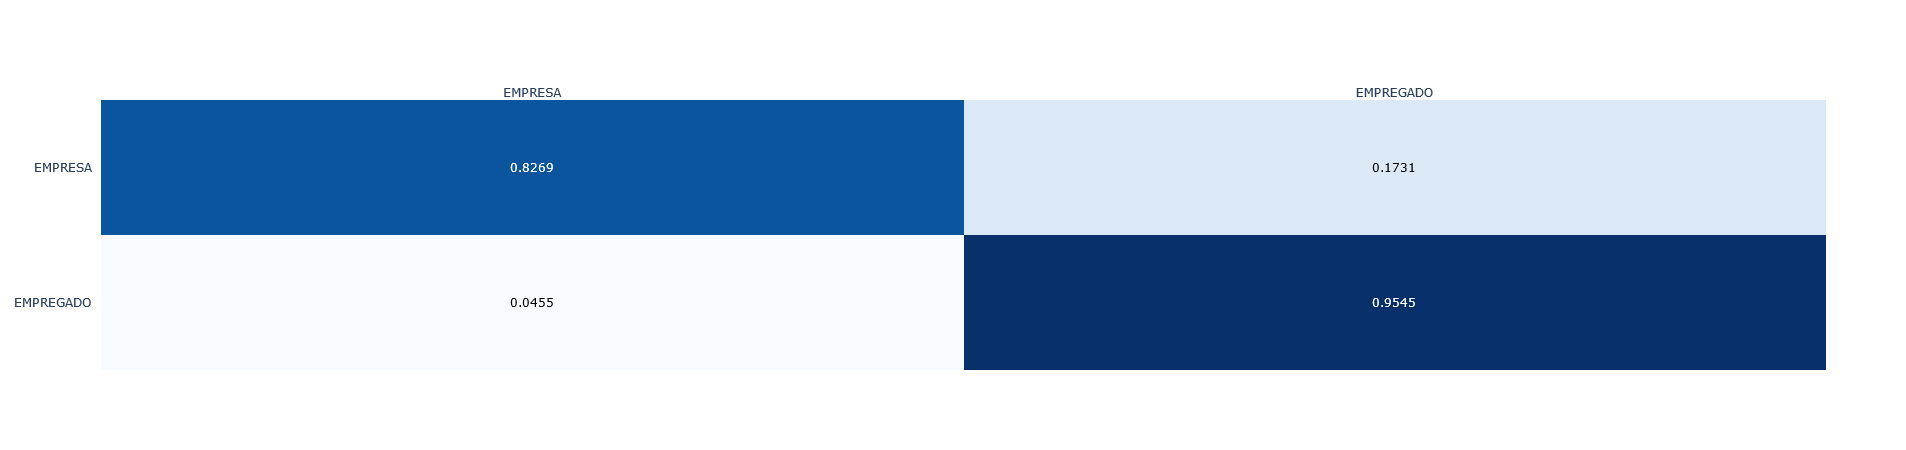


['Rocchio classifier', 0.9017170809623639, 0.9193055969444279, 0.8873419813269436, 0.9571510055927998]


In [28]:
from sklearn.neighbors import NearestCentroid

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid()),
                     ])
metricas = treinar_cv(text_clf, "Rocchio classifier")
medias_cv = medias_cv.append( [metricas] )

## Gradient Boosting Classifier

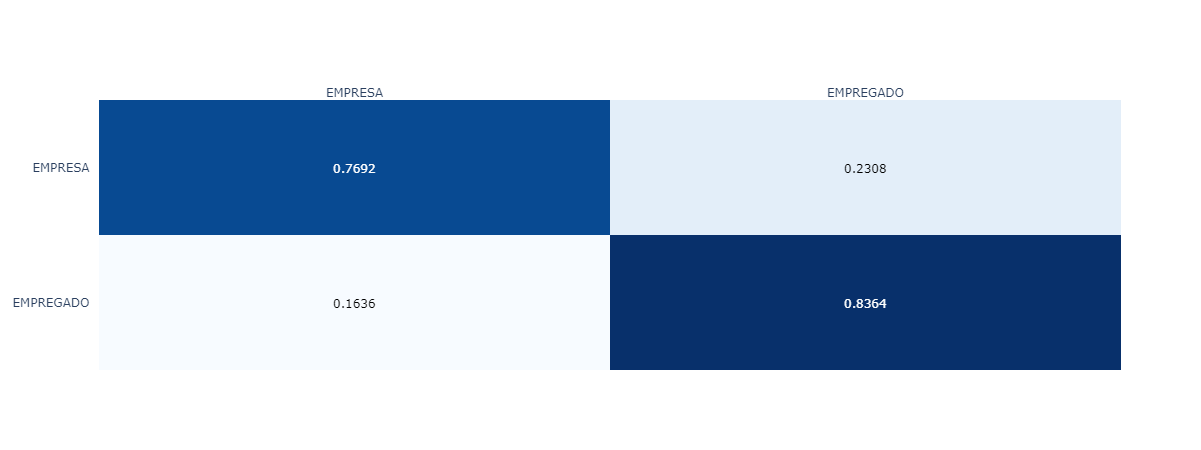


['Gradient Boosting Classifier', 0.8084755914944594, 0.8335797413572179, 0.8362057681182106, 0.8386585586222609]


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100)),
                     ])
metricas = treinar_cv(text_clf, "Gradient Boosting Classifier")
medias_cv = medias_cv.append( [metricas] )

## Naive Bayes Classifier

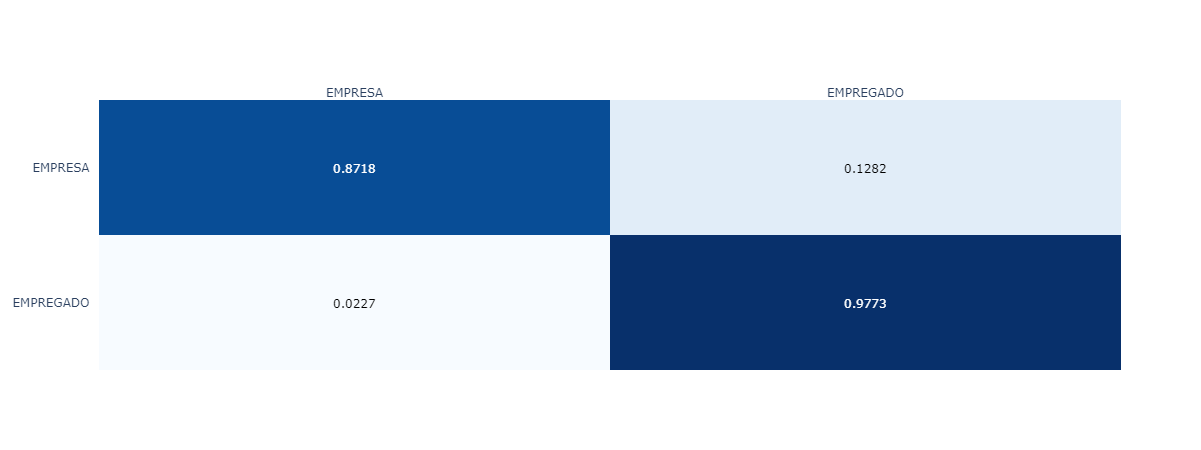


['Naive Bayes Classifier', 0.93361285814116, 0.9431505456520616, 0.9123694613411554, 0.9769147005444647]


In [30]:
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
metricas = treinar_cv(text_clf, "Naive Bayes Classifier")
medias_cv = medias_cv.append( [metricas] )

## K-nearest Neighbor

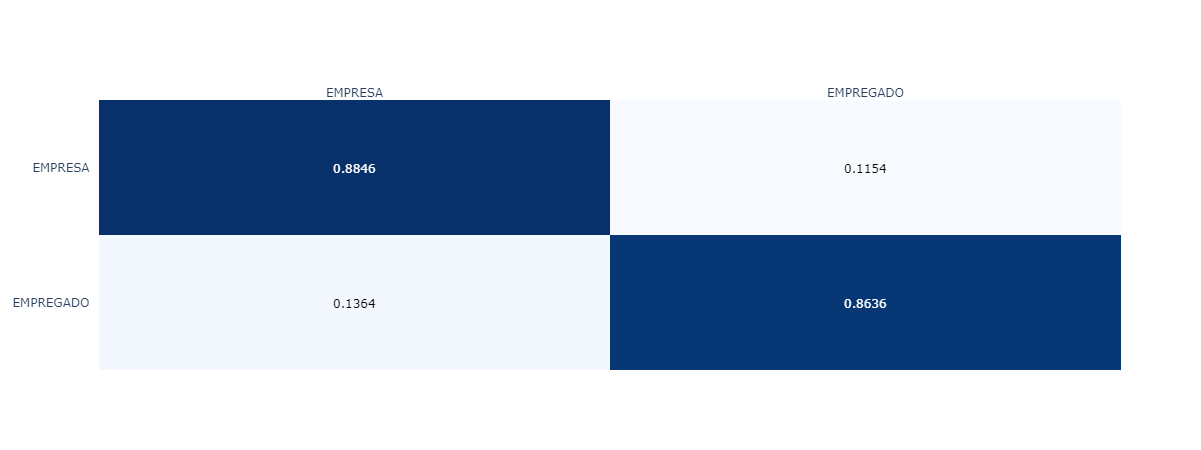


['K-nearest Neighbor', 0.8721174004192872, 0.8864167599781079, 0.9139194811434742, 0.8695368739807423]


In [31]:
from sklearn.neighbors import KNeighborsClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])
metricas = treinar_cv(text_clf, "K-nearest Neighbor")
medias_cv = medias_cv.append( [metricas] )

## Support Vector Machine (SVM)

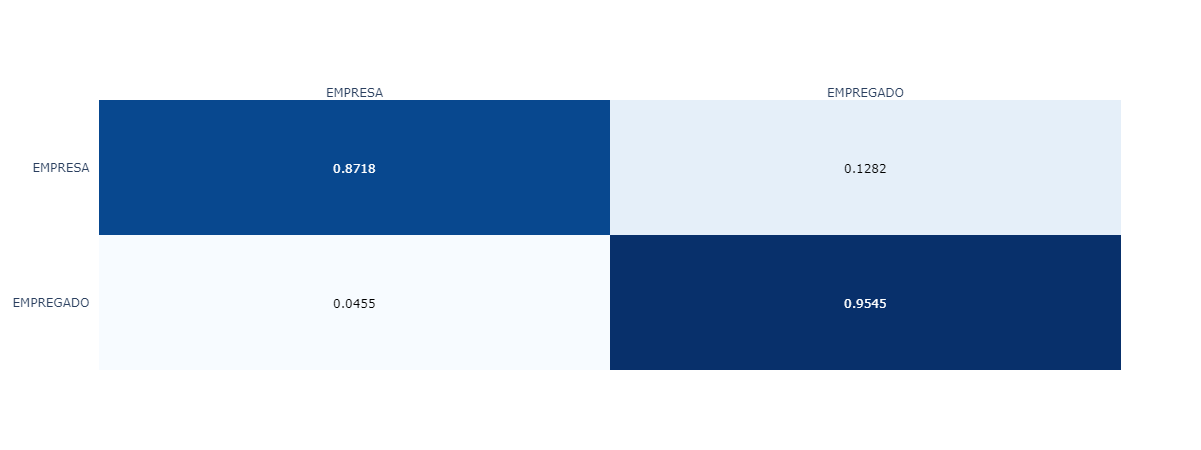


['Support Vector Machine (SVM)', 0.9202855146251373, 0.9328200331428971, 0.9127160346054356, 0.9571510055927998]


In [32]:
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
metricas = treinar_cv(text_clf, "Support Vector Machine (SVM)")
medias_cv = medias_cv.append( [metricas] )

## Decision Tree

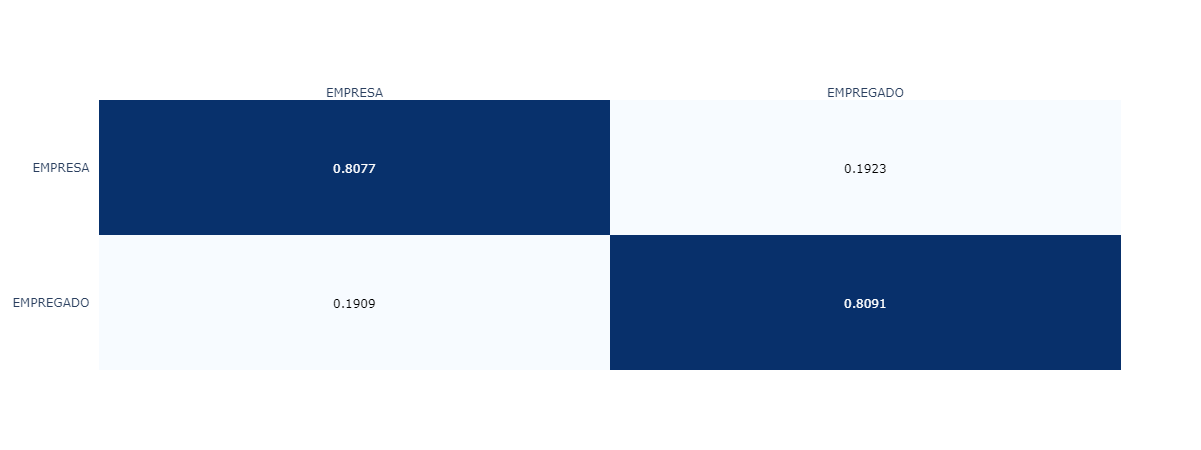


['Decision Tree', 0.8085255066387143, 0.8298989382213585, 0.8605467998404596, 0.8125821719547413]


In [33]:
from sklearn import tree

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier()),
                     ])
metricas = treinar_cv(text_clf, "Decision Tree")
medias_cv = medias_cv.append( [metricas] )

## Random Forest

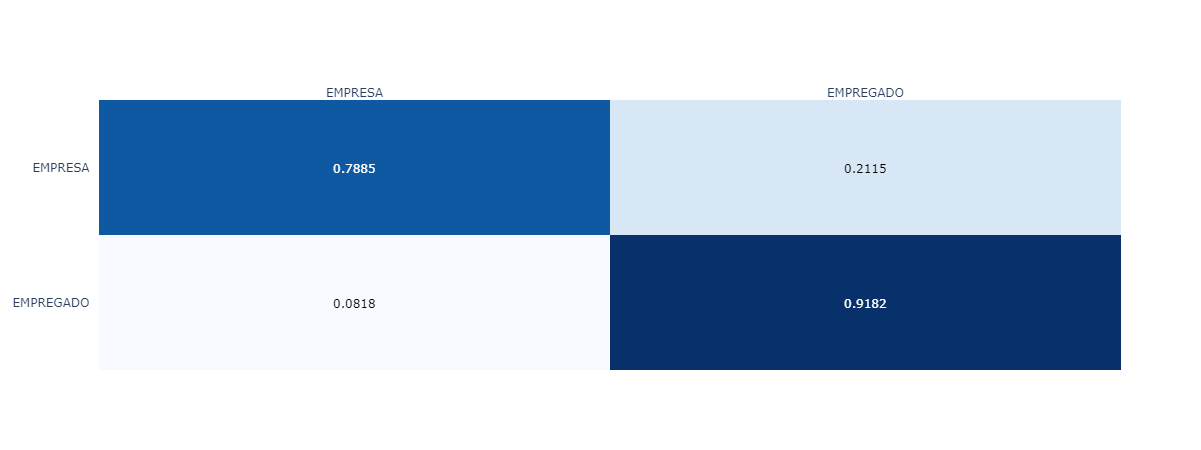


['Random Forest', 0.8643805530597984, 0.8876947261259611, 0.8601311464652176, 0.9244764620911886]


In [34]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100)),
                     ])
metricas = treinar_cv(text_clf, "Random Forest")
medias_cv = medias_cv.append( [metricas] )

## Análise dos resultados

In [35]:
colunas = ["Classificador", "Accuracy", "F1", "Precision", "Recall"]
medias_cv.columns = colunas
medias_cv = medias_cv.set_index("Classificador")
medias_cv = medias_cv.round(4)
medias_cv

,Accuracy,F1,Precision,Recall
Classificador,,,,
Rocchio classifier,0.9017,0.9193,0.8873,0.9572
Gradient Boosting Classifier,0.8085,0.8336,0.8362,0.8387
Naive Bayes Classifier,0.9336,0.9432,0.9124,0.9769
K-nearest Neighbor,0.8721,0.8864,0.9139,0.8695
Support Vector Machine (SVM),0.9203,0.9328,0.9127,0.9572
Decision Tree,0.8085,0.8299,0.8605,0.8126
Random Forest,0.8644,0.8877,0.8601,0.9245


In [36]:
import plotly.graph_objects as go
from plotly.offline import iplot

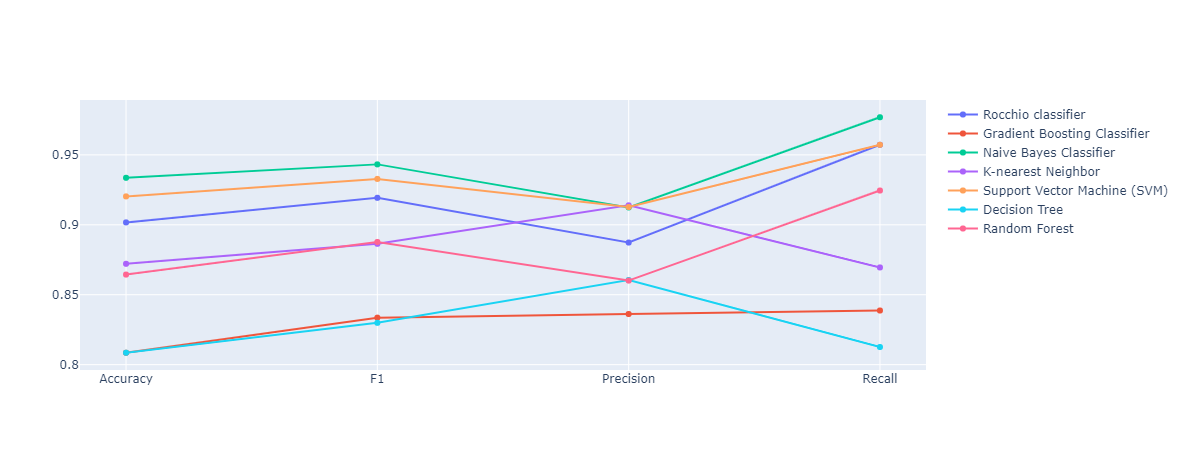

In [37]:
iplot( { "data": [ go.Scatter(x=colunas[1:], y=medias_cv.iloc[i,:], name=medias_cv.index[i] ) for i in range( len( medias_cv ) ) ] } )

## Teste final

Será utilizado 70% para treinamento e 30% para teste final

In [38]:
medias_teste_final = pd.DataFrame( )

def treinar_teste_final(model, nome_classificador):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    ####################
    #metricas
    ####################    
    accuracy = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    
    metricas_modelo = [accuracy, f1, precision, recall]
    metricas_modelo.insert(0, nome_classificador)
    print(metricas_modelo)

    ####################
    #confusion matrix
    ####################
    #calcula media da Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predicted, labels=[EMPRESA, EMPREGADO])
    c = conf_matrix
    #normaliza a matriz = transforma a contagem de instancias em porcentagem
    #https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
    normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
    
    #grafico
    x = ["EMPRESA", "EMPREGADO"]
    y = ["EMPRESA", "EMPREGADO"]

    fig = ff.create_annotated_heatmap(normed_c.round(4), x=x, y=y, annotation_text=normed_c.round(4), colorscale='Blues')
    fig['layout']['yaxis']['autorange'] = "reversed"
    iplot(fig)
    
    return metricas_modelo

## Modelos

## Rocchio classifier

['Rocchio classifier', 0.9074074074074074, 0.923076923076923, 0.8737864077669902, 0.9782608695652174]


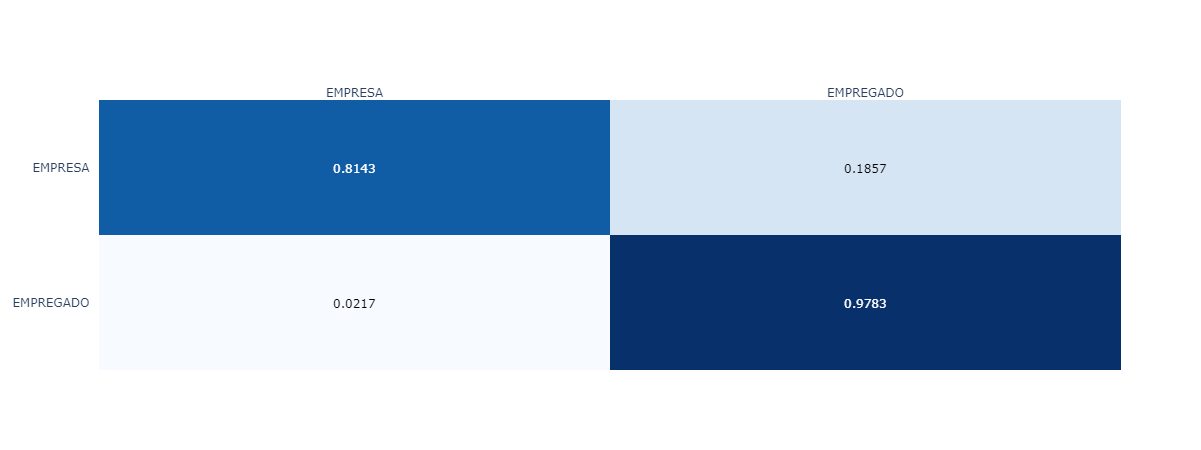

In [39]:
from sklearn.neighbors import NearestCentroid

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid()),
                     ])
metricas = treinar_teste_final(text_clf, "Rocchio classifier")
medias_teste_final = medias_teste_final.append( [metricas] )

## Gradient Boosting Classifier

['Gradient Boosting Classifier', 0.8024691358024691, 0.8315789473684211, 0.8061224489795918, 0.8586956521739131]


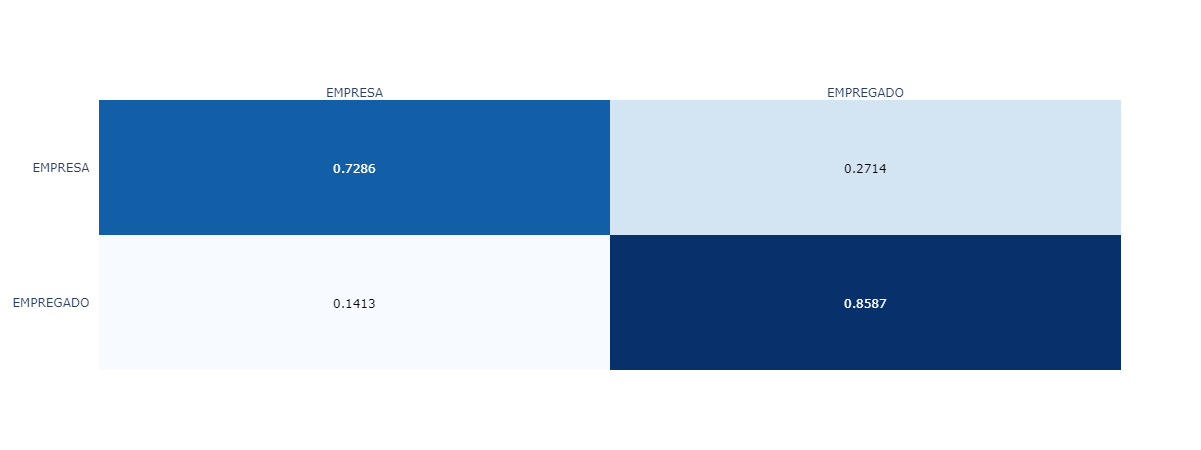

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100)),
                     ])
metricas = treinar_teste_final(text_clf, "Gradient Boosting Classifier")
medias_teste_final = medias_teste_final.append( [metricas] )

## Naive Bayes Classifier

['Naive Bayes', 0.9320987654320988, 0.9430051813471502, 0.900990099009901, 0.9891304347826086]


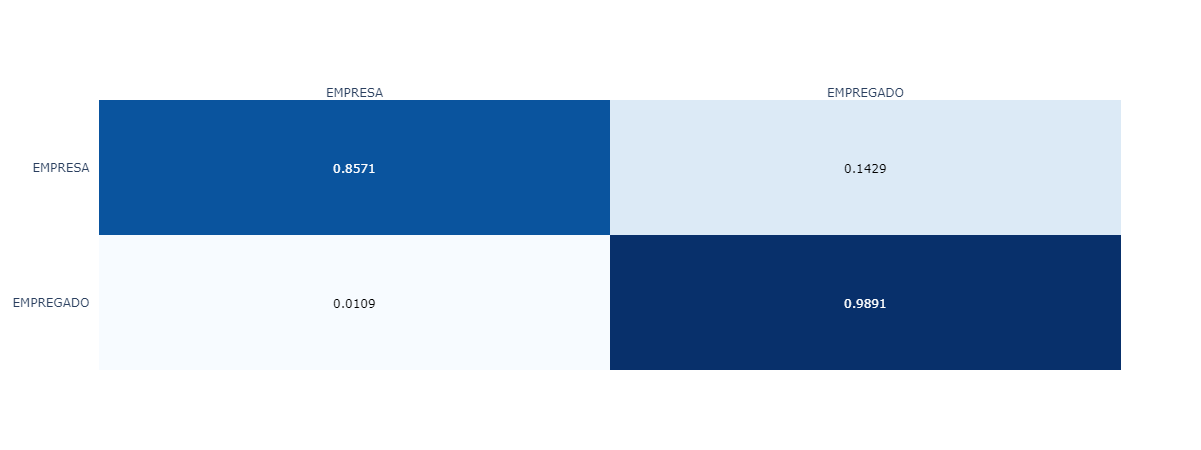

In [41]:
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
metricas = treinar_teste_final(text_clf, "Naive Bayes")
medias_teste_final = medias_teste_final.append( [metricas] )

## K-nearest Neighbor

['K-nearest Neighbor', 0.8950617283950617, 0.9050279329608939, 0.9310344827586207, 0.8804347826086957]


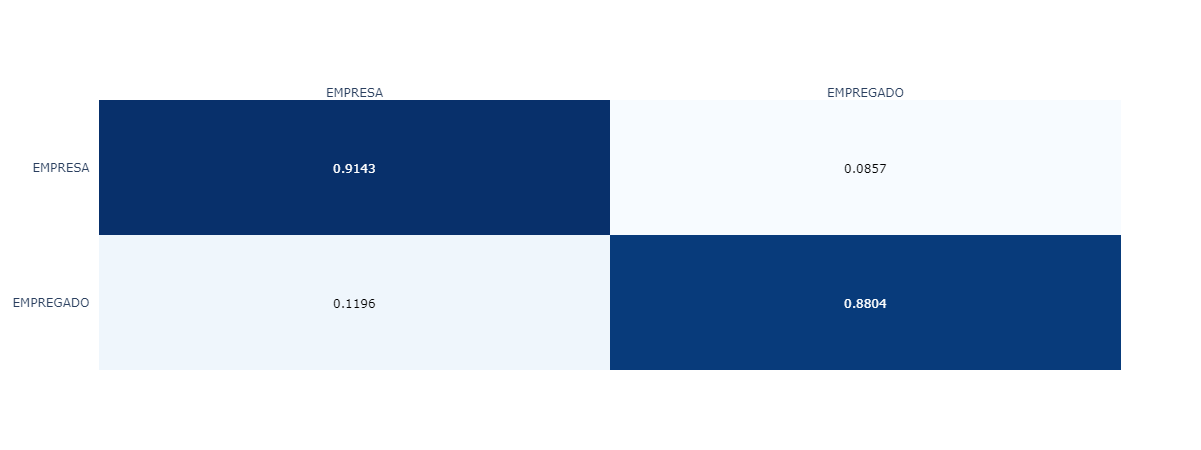

In [42]:
from sklearn.neighbors import KNeighborsClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])
metricas = treinar_teste_final(text_clf, "K-nearest Neighbor")
medias_teste_final = medias_teste_final.append( [metricas] )

## Support Vector Machine (SVM)

['Support Vector Machine (SVM)', 0.9320987654320988, 0.9430051813471502, 0.900990099009901, 0.9891304347826086]


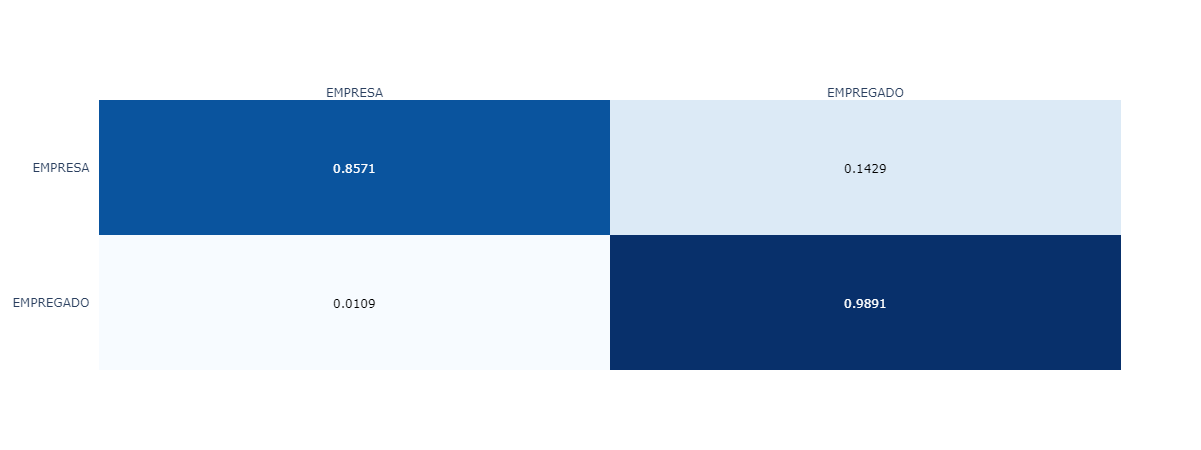

In [43]:
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
metricas = treinar_teste_final(text_clf, "Support Vector Machine (SVM)")
medias_teste_final = medias_teste_final.append( [metricas] )

## Decision Tree

['Decision Tree', 0.808641975308642, 0.8287292817679558, 0.8426966292134831, 0.8152173913043478]


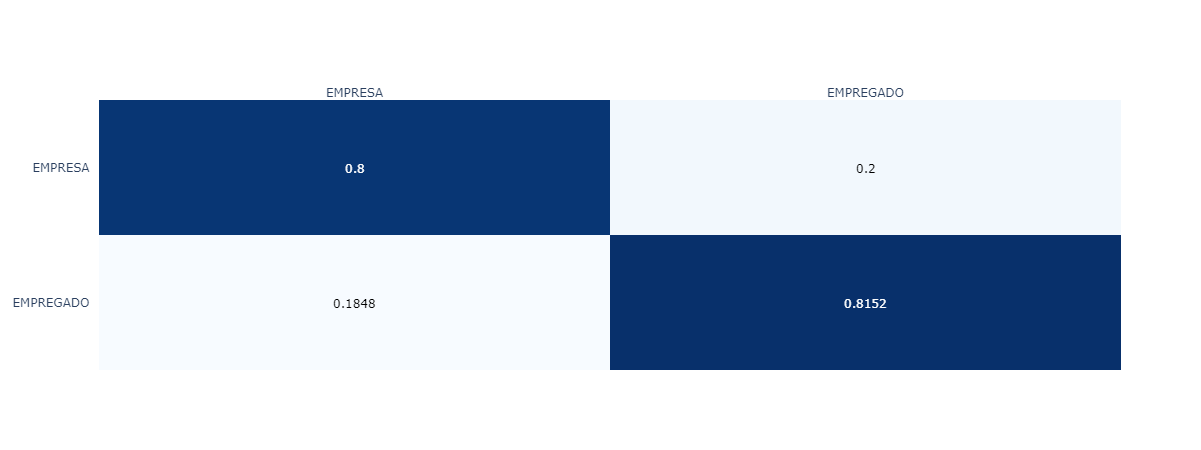

In [44]:
from sklearn import tree

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier()),
                     ])
metricas = treinar_teste_final(text_clf, "Decision Tree")
medias_teste_final = medias_teste_final.append( [metricas] )

## Random Forest

['Random Forest', 0.8950617283950617, 0.91005291005291, 0.8865979381443299, 0.9347826086956522]


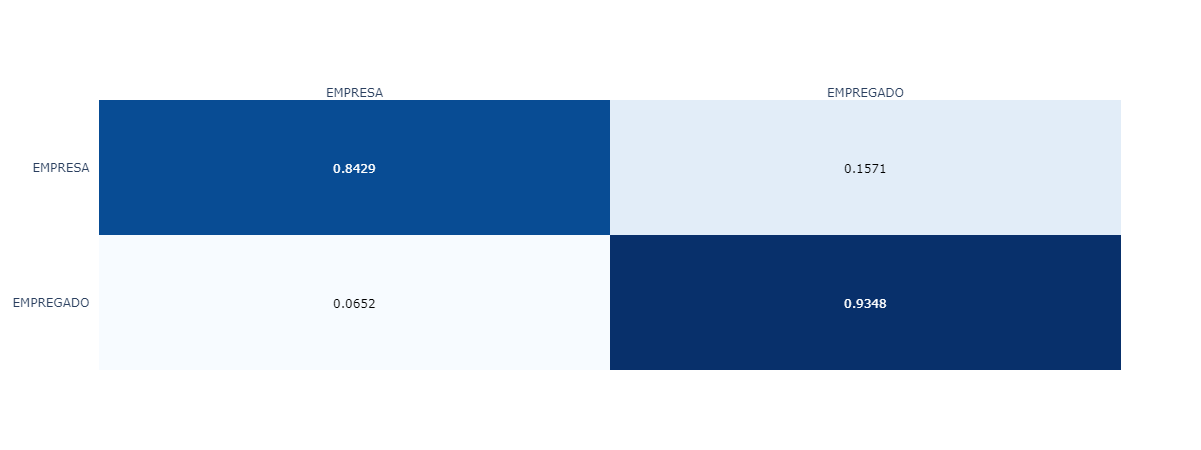

In [45]:
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100)),
                     ])
metricas = treinar_teste_final(text_clf, "Random Forest")
medias_teste_final = medias_teste_final.append( [metricas] )

## Análise dos resultados

In [46]:
colunas = ["Classificador", "Acurácia", "F1", "Precisão", "Revocação"]
medias_teste_final.columns = colunas
medias_teste_final = medias_teste_final.set_index("Classificador")
medias_teste_final = medias_teste_final.round(4)
medias_teste_final

,Acurácia,F1,Precisão,Revocação
Classificador,,,,
Rocchio classifier,0.9074,0.9231,0.8738,0.9783
Gradient Boosting Classifier,0.8025,0.8316,0.8061,0.8587
Naive Bayes,0.9321,0.9430,0.9010,0.9891
K-nearest Neighbor,0.8951,0.9050,0.9310,0.8804
Support Vector Machine (SVM),0.9321,0.9430,0.9010,0.9891
Decision Tree,0.8086,0.8287,0.8427,0.8152
Random Forest,0.8951,0.9101,0.8866,0.9348


In [47]:
medias_teste_final.to_excel("medias_teste_final.xlsx")

In [64]:
medias_teste_final.to_csv( "medias_teste_final_2.csv", encoding='utf-8', index=False )

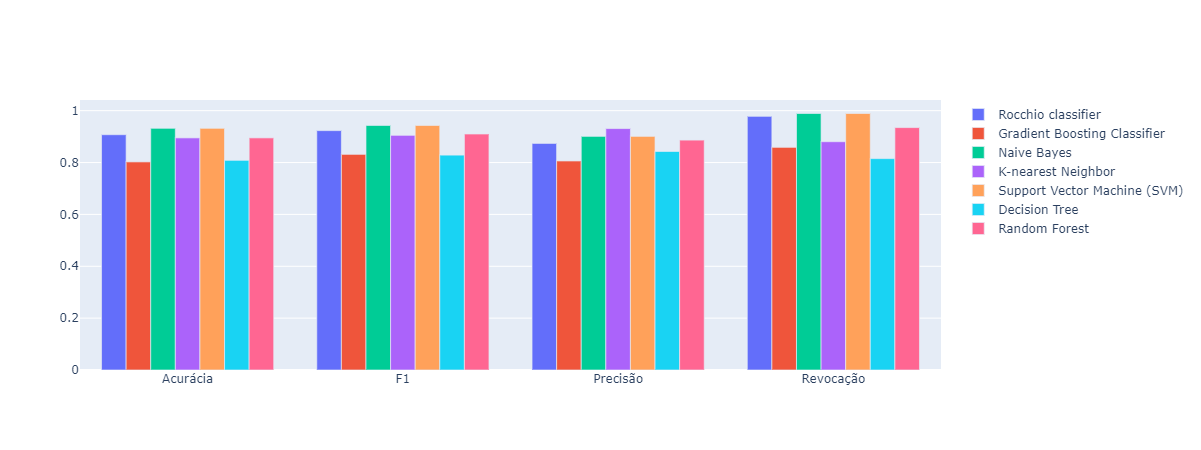

In [53]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.offline import iplot

iplot( { "data": [ go.Bar(x=colunas[1:], y=medias_teste_final.iloc[i,:], name=medias_teste_final.index[i] ) for i in range( len( medias_teste_final ) ) ] } )

## Retreinamento do classificador que teve a melhor métrica de F1 com todo o dataset

É utilizado todo o dataset para que ele possa absorver o máximo do dataset anotado

### Support Vector Machine (SVM)

In [49]:
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
text_clf.fit(df_tudo["RECORRENTE"].values, df_tudo["ROTULO"].values)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

### Salvamento do modelo para utilização posterior

In [50]:
from joblib import dump
dump(text_clf, 'ml_model_recorrente_SVM.joblib')

['ml_model_recorrente_SVM.joblib']